In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from scipy.optimize import curve_fit

In [2]:
particles = {
    '-6': '4-HELIUM',
    '-5': '3-HELIUM',
    '-4': 'TRITON',
    '-3': 'DEUTERON',
    '-2': 'HEAVYION',
    '1' : 'PROTON'  ,
    '2' : 'HEAVYION', 
    '3' : 'ELECTRON',
    '4' : 'POSITRON',
    '5' : 'NEUTRIE',
    '6' : 'ANEUTRIE',
    '7' : 'PHOTON',
    '8' : 'NEUTRON',
    '9' : 'ANEUTRON',
    '10': 'MUON+',
    '11': 'MUON-',
    '12': 'KAONLONG',
    '13': 'PION+',
    '14': 'PION-',
    '15': 'KAON+',
    '16': 'KAON-', 
    '17': 'LAMBDA',
    '18': 'ALAMBDA',
    '19': 'KAONSHORT',
    '20': 'SIGMA-',
    '21': 'SIGMA+',
    '22': 'SIGMAZER',
    '23': 'PIZERO',
    '24': 'KAONZERO',
    '25': 'AKAONZER',
    '31': 'ASIGMA-',
    '32': 'ASIGMAZE',
    '33': 'ASIGMA+',
    '34': 'XSIZERO',    
    '35': 'AXSIZERO',
    '36': 'XSI-',
    '37': 'AXSI+',
    '38': 'OMEGA-',
    '39': 'AOMEGA-'
    
}

mass = {
    'PIZERO': 135.0,
    'PION+' : 139.6,
    'PION-' : 139.6,
    'PROTON': 938.3,
    'KAONZERO' : 497.6,
    'AKAONZER' : 497.6,
    'KAON+'    : 493.7,
    'KAON-'    : 493.7,
    'KAONSHORT': 497.6,
    'KAONLONG' : 497.6
    
}

In [3]:
def TotMomentum(px, py,pz):
    p = (px **2 + py **2 + pz**2 )**0.5
    return(p)

def Angle(pdir, ptot, px): #pdid is momentum in direction of beam (ie z)
    theta = np.arccos(pdir/ptot)
    if px > 0: #Give directionality to the angle using x arbitrarily
        return(theta)
    else:
        return(-theta)
    
def Gauss(x, a, x0, mu): #Define gaussian for fit
    return a*np.exp(-(x-x0)**2/(2*mu))

In [4]:
def PlottableData(eventList, particleInterested, nominalEnergy, massDict = mass, acceptance = 0.1): #from the list of events 
                                      #returns the angle. For the masses in calculation defaults to dictionary defined above
    direction = list()
    
    for item in eventList:
        
        if item[0] == particleInterested: 
            
            pTot = TotMomentum(*item[2])
            
            #eneries from data in GeV but mass in MeV, so converted when used
            eventEnergy = (pTot ** 2 + (mass[particleInterested] * 10 **-3)** 2) **0.5 
            #remove particles if momentum spread too large
            if abs(eventEnergy-nominalEnergy)/nominalEnergy <= acceptance: 
                direction.append(Angle(item[2][2], pTot, item[2][0]))
    return(direction)

In [5]:
material = "carbon"
material = material.upper()
length = 47
energy = 400

particleInterested = 'pion+'
particleInterested = particleInterested.upper()

nominalEnergyList = [4, 6, 8.5]

path = r'C:\Users\mussolini\Desktop\PhD general\Impinging'
folderName = material + "_" + str(length) + "cm_" + str(energy) + "GeV"

fullpath = os.path.join(path, folderName)

file = fullpath + r"/input_0.dat" 

In [6]:
eventList = list() #list of type, position list, momentum list for each particle

with open(file, mode = 'r') as infile:
    reader = csv.reader(infile)
    for i, line in enumerate(reader):

        pclePos = []
        pcleMmt = []
        
        particleType = particles[line[0].split()[1]] #save particle id
        
        pclePos.append(float(line[0].split()[2])) #save psition in x
        pclePos.append(float(line[0].split()[3])) #y
        pclePos.append(float(line[0].split()[4])) #z
        
        pcleMmt.append(float(line[0].split()[5])) #save momentum in x 
        pcleMmt.append(float(line[0].split()[6])) #y
        pcleMmt.append(float(line[0].split()[7])) #z
        
        eventList.append([particleType, pclePos, pcleMmt])

Standard deviation of: 7.87E-02 rads at 4.0 GeV
Standard deviation of: 5.85E-02 rads at 6.0 GeV
Standard deviation of: 3.96E-02 rads at 8.5 GeV


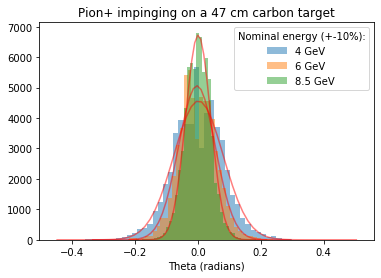

In [11]:
for nominalEnergy in nominalEnergyList:
    direction = np.asarray(PlottableData(eventList, particleInterested, nominalEnergy))
    weights = abs(np.sin(direction)**-1) #will need to be weighted as spherical coordinate
    
    binHeight, binEnds = np.histogram(direction, weights = weights, bins = int(len(direction)**0.5))
    binCenters = (binEnds[:-1] + binEnds[1:])/2
    mean = np.mean(direction/weights)
    mu = np.std(direction/weights)**2 #variance
    
    popt, pcov = curve_fit(Gauss,binCenters,binHeight,p0=[1,mean,mu]) #get optimal gaussian parameters, p0 is initial guess
    #popt has same form as p0, ie amplitude, mean, mu 
    
    plt.plot(binCenters, Gauss(binCenters, *popt), 'r-', alpha = 0.5)
    plt.hist(direction, bins = int(len(direction)**0.5), weights  = weights, label = str(nominalEnergy) + ' GeV' , alpha = 0.5)
    plt.title(particleInterested.capitalize() + ' impinging on a ' + str(length) + ' cm ' + material.lower() + ' target' )
    print("Standard deviation of: %2.2E rads at %2.1f GeV" %(popt[2]**0.5, nominalEnergy))
    
plt.legend(title = "Nominal energy (+-10%):")
plt.xlabel('Theta (radians)')
plt.savefig(path + '\\' + folderName)
plt.show()